# Imports

In [2]:
from numpy.random import seed
seed(13)
from tensorflow import set_random_seed
set_random_seed(13)

from keras import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, MaxPooling3D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras.models import model_from_json
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
import numpy as np
import os
import cv2             
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
import shutil
import os

# Folder structure

In [ ]:
FLOWER_DAISY_DIR='datasets/flowers/daisy'
FLOWER_SUNFLOWER_DIR='datasets/flowers/sunflower'
FLOWER_TULIP_DIR='datasets/flowers/tulip'
FLOWER_DANDI_DIR='datasets/flowers/dandelion'
FLOWER_ROSE_DIR='datasets/flowers/rose'

# Load data

## Manually

In [ ]:
X = [] # FEATURES
y = [] # CLASSES

IMG_SIZE=150

def load_flower_data(DIR, flower_type,):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR, img)
        img_read = cv2.imread(path, cv2.IMREAD_COLOR) # INCLUDE COLOR
        
        if img_read is not None:
            img_resized = cv2.resize(img_read, (IMG_SIZE,IMG_SIZE))
            X.append(np.array(img_resized))
            y.append(str(flower_type))
        else:
            print(DIR, img)

'''
datasets/flowers/daisy .ipynb_checkpoints
datasets/flowers/dandelion flickr.py
datasets/flowers/dandelion flickr.pyc
datasets/flowers/dandelion run_me.py
'''

In [ ]:
def init_all_data_from_dataset():
    load_flower_data(FLOWER_DAISY_DIR, "Daisy")
    load_flower_data(FLOWER_SUNFLOWER_DIR, "Sunflower")
    load_flower_data(FLOWER_TULIP_DIR, "Tulip")
    load_flower_data(FLOWER_DANDI_DIR, "Dandelion")
    load_flower_data(FLOWER_ROSE_DIR, "Rose")
    joblib.dump(X, "X_CLEAN.joblib")
    joblib.dump(y, "y_CLEAN.joblib")
    return X, y

In [35]:
X = [] # FEATURES
y = [] # CLASSES

def load_saved_dataframes():
    X = joblib.load("X_CLEAN.joblib")
    y = joblib.load("y_CLEAN.joblib")
    return X, y

In [ ]:
X, y = init_all_data_from_dataset()

In [36]:
X, y = load_saved_dataframes()

In [37]:
def visualize_flowers():
    fig, ax = plt.subplots(3,3)
    fig.set_size_inches(10,10)
    for i in range(3):
        for j in range (3):
            r = rand.randint(0, len(y))
            ax[i,j].set_title(y[r])
            RGB_img = cv2.cvtColor(X[r], cv2.COLOR_BGR2RGB)
            ax[i,j].imshow(RGB_img)

    plt.tight_layout()

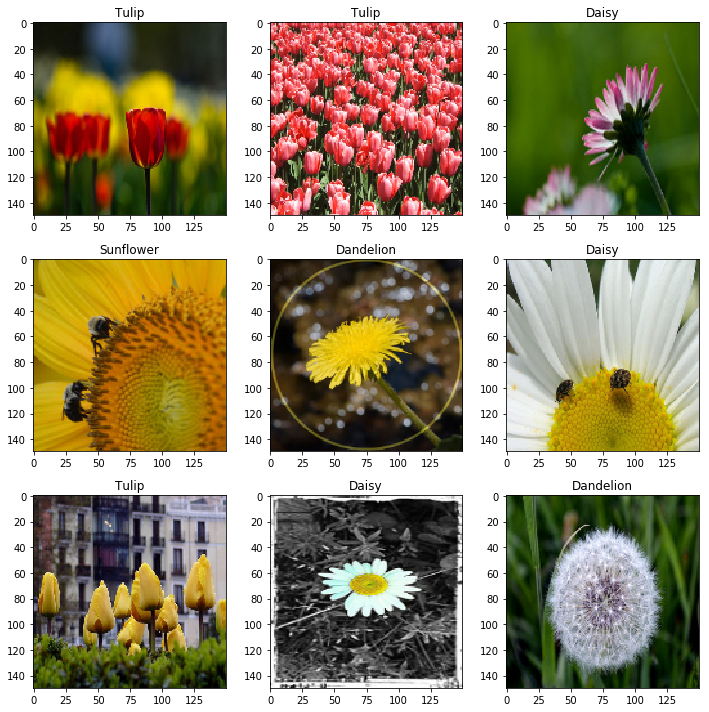

In [40]:
visualize_flowers()

# Data preprocessing

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=True)

In [ ]:
#from category_encoders import OneHotEncoder
#categorical_encoder = OneHotEncoder(return_df=False, impute_missing=False, handle_unknown="ignore")

In [ ]:
def preprocess_data(X, y, last_version=True):

    X = np.asarray(X)
    y = np.asarray(y)

    if last_version:
        y = one_hot_encoder.fit_transform(y.reshape(-1, 1))
    else:
        y = categorical_encoder.fit_transform(y.reshape(-1, 1))

    X = X / 255
    
    return X, y

In [ ]:
def train_test_val_split(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
X, y = preprocess_data(X, y)
X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_split(X, y)
X_train.shape, X_val.shape, X_test.shape

# Model

In [2]:
model = Sequential()

model.add((Conv2D(32, kernel_size=3, activation='relu', input_shape=(150, 150, 3))))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu"))
model.add(Dense(5, activation='softmax'))

In [10]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

# Training

## Manual

In [ ]:
epochs = 25
batch_size = 32

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

## Generator

In [2]:
def get_image_data_generators_agumented():
    
    # Get training data, augmented
    data_generator_train = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, rotation_range=45, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
    train_generator = data_generator_train.flow_from_directory('datasets/training/', target_size=(150, 150), shuffle=True, seed=13, class_mode='categorical', batch_size=32)
  
    # Get validation and test data, not augmented
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    validation_generator = test_val_datagen.flow_from_directory('datasets/validation/', target_size=(150, 150), shuffle=True, seed=13, class_mode='categorical', batch_size=32)
    test_generator = test_val_datagen.flow_from_directory('datasets/testing/', target_size=(150, 150), shuffle=False, seed=13, class_mode=None, batch_size=1)
 
    return train_generator, validation_generator, test_generator

In [3]:
def get_image_data_generators_not_agumented():
    datagen_not_agumented = ImageDataGenerator(rescale=1./255)
    train_generator = datagen_not_agumented.flow_from_directory('datasets/training/', target_size=(150, 150), shuffle=True, seed=13, class_mode='categorical', batch_size=32)
    validation_generator = datagen_not_agumented.flow_from_directory('datasets/validation/', target_size=(150, 150), shuffle=True, seed=13, class_mode='categorical', batch_size=32)
    test_generator = datagen_not_agumented.flow_from_directory('datasets/testing/', target_size=(150, 150), shuffle=False, seed=13, class_mode=None, batch_size=1)
 
    return train_generator, validation_generator, test_generator

In [12]:
train_generator, validation_generator, test_generator = get_image_data_generators_not_agumented()

Found 2580 images belonging to 5 classes.
Found 860 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


In [30]:
training_samples = len(train_generator.classes)
validation_samples = len(validation_generator.classes)
test_samples = len(test_generator.classes)

In [28]:
epochs = 25

In [29]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=training_samples // epochs, # steps_per_epoch * epochs = training samples
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps= validation_samples // epochs) # validation_steps * epochs = validation samples

Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 0.1266 - acc: 0.9375 - val_loss: 2.2337 - val_acc: 0.6875


In [ ]:
def print_training_score(history):

    print(history.history.keys())
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    #plt.savefig("model_acc_augmentation_75")
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    #plt.savefig("model_loss_augmentation_75")
    

In [ ]:
print_training_score(history)

# Evaluation

In [ ]:
def predict_classes_manually(X_test, y_test):
    y_pred = model.predict_classes(X_test) 
    y_test = one_hot_encoder.inverse_transform(y_test)
    y_test = LabelEncoder().fit_transform(y_test)

In [ ]:
def predict_classes_from_generator():
    filenames = test_generator.filenames
    nb_samples = len(filenames)
    test_generator.reset()
    pred = model.predict_generator(test_generator, steps = nb_samples)
    predicted_class_indices = np.argmax(pred,axis=1)
    return predicted_class_indices

In [ ]:
def accuracy(matrix):
    correct_predictions = 0
    for i in range(5):
        for j in range(5):
            if i == j:
                correct_predictions += matrix.item(i, j)
    print("Accuracy = ", correct_predictions / matrix.sum())

In [ ]:
predict_classes_manually(X_test, y_test)

In [ ]:
y_pred = predict_classes_from_generator()

In [ ]:
cm = confusion_matrix(test_generator.classes, y_pred)

In [ ]:
accuracy(cm)

# Inception V3

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False)
#base_model = ResNet50(weights='imagenet', include_top=False)

In [ ]:
batch_size = 20

train_dir = 'datasets/training/'
validation_dir = 'datasets/validation/'
testing_dir = 'datasets/testing/'

def extract_features(directory, sample_count, augmented):
    
    print("Extract feature from ", directory)
    
    features = np.zeros(shape=(sample_count, 3, 3, 2048)) # InceptionV3 = (3, 3, 2048), ResNet50 = (5, 5, 2048) 
    labels = np.zeros(shape=(sample_count, 5))
    
    if augmented: 
        datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, rotation_range=45, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)
    
    generator = datagen.flow_from_directory(directory, target_size=(150,150), batch_size=batch_size, seed=13, class_mode='categorical')
    i = 0
    
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch)
        features[i * batch_size : (i+1) * batch_size] = features_batch
        labels[i * batch_size : (i+1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
            
    print("Done with ", directory)
    return features, labels

In [ ]:
# Training data augmented/not augmented depending on flag
train_features, train_labels = extract_features(train_dir, 2580, augmented=True)

In [ ]:
validation_features, validation_labels = extract_features(validation_dir, 860, augmented=False)
test_features, test_labels = extract_features(testing_dir, 860, augmented=False)

In [ ]:
train_features = np.reshape(train_features, (2580, 3*3*2048))
validation_features = np.reshape(validation_features, (860, 3*3*2048))
test_features = np.reshape(test_features, (860, 3*3*2048))

In [ ]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=train_features[0].shape))
model.add(Dropout(0.5))
'''
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
'''
model.add(Dense(5, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
optimizer = RMSprop(lr=0.0002, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_features, train_labels, epochs=50, batch_size=32, validation_data=(validation_features, validation_labels))

In [ ]:
print_training_score(history)

In [ ]:
y_pred = model.predict_classes(test_features)

In [ ]:
test_labels = np.argmax(test_labels, axis=1)

In [ ]:
cm = confusion_matrix(test_labels, y_pred)
cm

In [ ]:
accuracy(cm)

# Help Functions

## Save and load model

In [7]:
def save_model(model, name):
    # Serialize model to JSON
    model_json = model.to_json()
    with open("models/" + name + ".json", "w") as json_file:
        json_file.write(model_json)

    # Serialize weights to HDF5
    model.save_weights("models/" + name + ".h5")
    print("Saved model to disk")

In [8]:
def load_model(name):
    json_file = open("models/" + name + ".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("models/" + name + ".h5")
    model = loaded_model
    print("Loaded model from disk")
    return model

In [ ]:
save_model(model, "file_name")

In [9]:
model = load_model("file_name")

Loaded model from disk


## Generators - train, test, val split

In [ ]:
# https://github.com/keras-team/keras/issues/6452

def split_dataset_into_train_test_val_split(all_data_dir, training_data_dir, validation_data_dir, testing_data_dir, split_val):
    # Recreate testing and training directories
    if testing_data_dir.count('/') > 1:
        shutil.rmtree(testing_data_dir, ignore_errors=False)
        os.makedirs(testing_data_dir)
        print("Successfully cleaned directory " + testing_data_dir)
    else:
        print("Refusing to delete testing data directory " + testing_data_dir + " as we prevent you from doing stupid things!")
        
    if validation_data_dir.count('/') > 1:
        shutil.rmtree(training_data_dir, ignore_errors=False)
        os.makedirs(training_data_dir)
        print("Successfully cleaned directory " + validation_data_dir)
    else:
        print("Refusing to delete validation data directory " + validation_data_dir + " as we prevent you from doing stupid things!")

    if training_data_dir.count('/') > 1:
        shutil.rmtree(training_data_dir, ignore_errors=False)
        os.makedirs(training_data_dir)
        print("Successfully cleaned directory " + training_data_dir)
    else:
        print("Refusing to delete testing data directory " + training_data_dir + " as we prevent you from doing stupid things!")
        
    num_training_files = 0
    num_validation_files = 0
    num_testing_files = 0

    for subdir, dirs, files in os.walk(all_data_dir):
        category_name = os.path.basename(subdir)

        # Don't create a subdirectory for the root directory
        print(category_name + " vs " + os.path.basename(all_data_dir))
        if category_name == os.path.basename(all_data_dir):
            continue

        training_data_category_dir = training_data_dir + '/' + category_name
        validation_data_category_dir = validation_data_dir + '/' + category_name
        testing_data_category_dir = testing_data_dir + '/' + category_name

        if not os.path.exists(training_data_category_dir):
            os.mkdir(training_data_category_dir)
        
        if not os.path.exists(validation_data_category_dir):
            os.mkdir(validation_data_category_dir)
        
        if not os.path.exists(testing_data_category_dir):
            os.mkdir(testing_data_category_dir)

        for file in files:
            input_file = os.path.join(subdir, file)
            rand = np.random.rand(1)
            if  rand < split_val:
                shutil.copy(input_file, testing_data_dir + '/' + category_name + '/' + file)
                num_testing_files += 1
            elif rand > split_val and rand < split_val*2:
                shutil.copy(input_file, validation_data_dir + '/' + category_name + '/' + file)
                num_validation_files += 1
            else:
                shutil.copy(input_file, training_data_dir + '/' + category_name + '/' + file)
                num_training_files += 1

    print("Processed " + str(num_training_files) + " training files.")
    print("Processed " + str(num_validation_files) + " validation files.")
    print("Processed " + str(num_testing_files) + " testing files.")


In [ ]:
split_dataset_into_train_test_val_split('datasets/flowers/', 'datasets/training', 'datasets/validation', 'datasets/testing', 0.20)